In [1]:
%matplotlib inline

import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from abi.misc.dataset import Dataset
from abi.models.rnnvae import RNNVAE

In [2]:

def normalize(x, axes=(0)):
    mean = np.mean(x, axes)
    x = x - mean
    std = np.std(x, axes)
    x = x / std
    return dict(x=x, mean=mean, std=std)

def load_data(
        filepath,
        obs_keys=[
            'velocity',
            'jerk',
            'timegap',
            'time_to_collision',
            'lidar_1',
            'lidar_2',
            'rangerate_lidar_1',
            'rangerate_lidar_2'
        ],
        act_keys=[
            'accel',
        ],
        debug_size=None,
        y_key='beh_lon_T',
        y_1_val=1.,
        train_split=.8):
    
    f = h5py.File(filepath, 'r')
    x = f['risk/features']
    
    if debug_size is not None:
        x = x[:debug_size]
    # append a zero to the front of the timeseries dim of x
    # because the model assumes this occurs
    x = np.concatenate((np.zeros((x.shape[0],1,x.shape[2])), x), axis=1)
    feature_names=f['risk'].attrs['feature_names']
    
    y_idx = np.where(feature_names == y_key)[0]
    y = np.zeros(len(x))
    one_idxs = np.where(x[:,-1,y_idx] == y_1_val)[0]
    y[one_idxs] = 1
    
    obs_idxs = [i for (i,n) in enumerate(feature_names) if n in obs_keys]
    obs = x[:,:,obs_idxs]
    obs = normalize(obs, (0,1))['x']
    act_idxs = [i for (i,n) in enumerate(feature_names) if n in act_keys]
    act = x[:,:,act_idxs]
    act = normalize(act, (0,1))['x']
    
    n_samples, max_len, obs_dim = obs.shape
    max_len = max_len - 1 
    act_dim = act.shape[-1]
    lengths = np.ones(n_samples) * max_len
    
    # train val split
    tidx = int(train_split *  n_samples)
    val_obs = obs[tidx:]
    val_act = act[tidx:]
    val_lengths = lengths[tidx:]
    val_y = y[tidx:]
    obs = obs[:tidx]
    act = act[:tidx]
    lengths = lengths[:tidx]
    y = y[:tidx]
    
    return dict(
        obs=obs,
        act=act,
        y=y,
        obs_keys=obs_keys,
        act_keys=act_keys,
        lengths=lengths,
        val_obs=val_obs,
        val_act=val_act,
        val_lengths=val_lengths,
        val_y=val_y,
        max_len=max_len,
        obs_dim=obs_dim,
        act_dim=act_dim
    )

In [3]:
data = load_data(
    filepath='../../data/trajectories/artificial.h5',
    debug_size=20000
)
obs = data['obs']
act = data['act']
lengths = data['lengths']
y = data['y']
obs_keys = data['obs_keys']
act_keys = data['act_keys']
max_len = data['max_len']
obs_dim = data['obs_dim']
act_dim = data['act_dim']
val_obs, val_act, val_lengths, val_y = data['val_obs'], data['val_act'], data['val_lengths'], data['val_y']

In [4]:
batch_size = 100
dataset = Dataset(np.copy(obs), np.copy(act), np.copy(lengths), batch_size, shuffle=True)

In [5]:
z_dim = 2

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = RNNVAE(
    max_len, 
    obs_dim, 
    act_dim, 
    batch_size, 
    z_dim=z_dim, 
    enc_hidden_dim=16,
    dec_hidden_dim=16,
    kl_steps=1000
)
sess.run(tf.global_variables_initializer())

In [11]:
model.train(dataset, n_epochs=10, verbose=True)

train epoch: 2 / 5 batch: 83 / 160 data_loss: 1.25741  kl_loss: 0.20014 

KeyboardInterrupt: 

In [12]:
max_samples = 1000
info = model.reconstruct(obs[:max_samples], act[:max_samples], lengths[:max_samples])

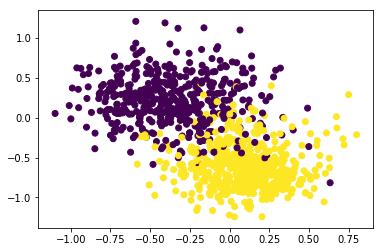

In [13]:
plt.scatter(info['mean'][:,0], info['mean'][:,1], c=y[:max_samples])

In [14]:
info = model.reconstruct(val_obs[:max_samples], val_act[:max_samples], val_lengths[:max_samples])

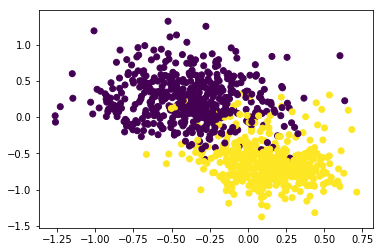

In [15]:
plt.scatter(info['mean'][:,0], info['mean'][:,1], c=val_y[:max_samples])